In [1]:
import numpy as np
import pandas as pd
from surprise import Reader, Dataset
from tqdm import tqdm
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from collections import defaultdict
from math import log2
from sklearn.utils import resample
tqdm.pandas()
from surprise import NMF

In [2]:
# Load and filter data
interactions = pd.read_pickle('../Pickle/interactions.pkl')
books = pd.read_pickle('../Pickle/books.pkl')
interactions = interactions[['user_id', 'book_id', 'rating', 'is_read']]  

In [3]:
interactions = interactions[interactions['rating'] != 0]

In [4]:
def split_data_with_single_interactions(interactions):
    # Identify users and books that appear only once in the dataset
    user_counts = interactions['user_id'].value_counts()
    book_counts = interactions['book_id'].value_counts()

    # Find interactions where user or book appears only once
    single_interactions = interactions[
        interactions['user_id'].isin(user_counts[user_counts == 1].index) | 
        interactions['book_id'].isin(book_counts[book_counts == 1].index)
    ]

    # Remove those interactions from the main dataset
    remaining_interactions = interactions[~interactions.index.isin(single_interactions.index)]

    # Split the remaining interactions into train and test using sklearn's train_test_split
    train_df, test_df = train_test_split(remaining_interactions, test_size=0.2, random_state=42)

    # Add the single interactions to the training set
    train_df = pd.concat([train_df, single_interactions], ignore_index=True)


    return train_df, test_df

train_df, test_df = split_data_with_single_interactions(interactions)

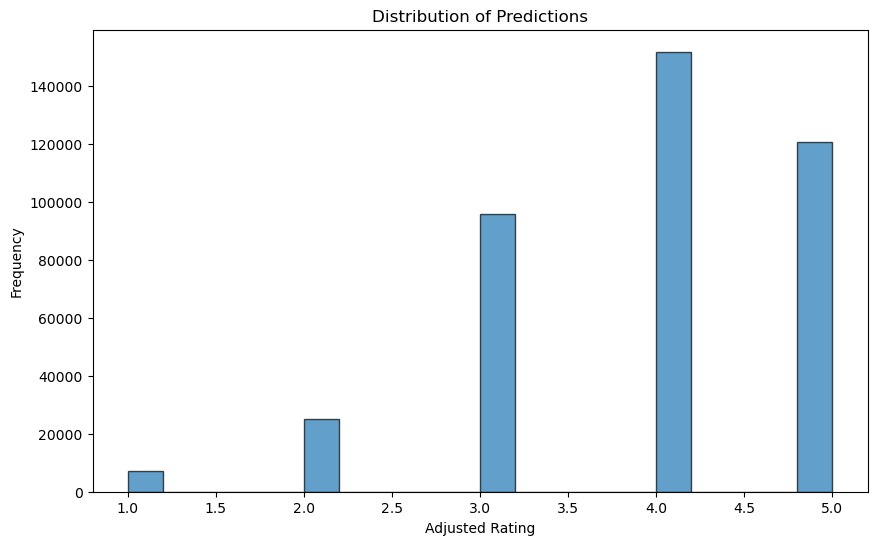

In [5]:
import matplotlib.pyplot as plt


# Plot the distribution of adjusted ratings
plt.figure(figsize=(10, 6))
plt.hist(train_df['rating'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()

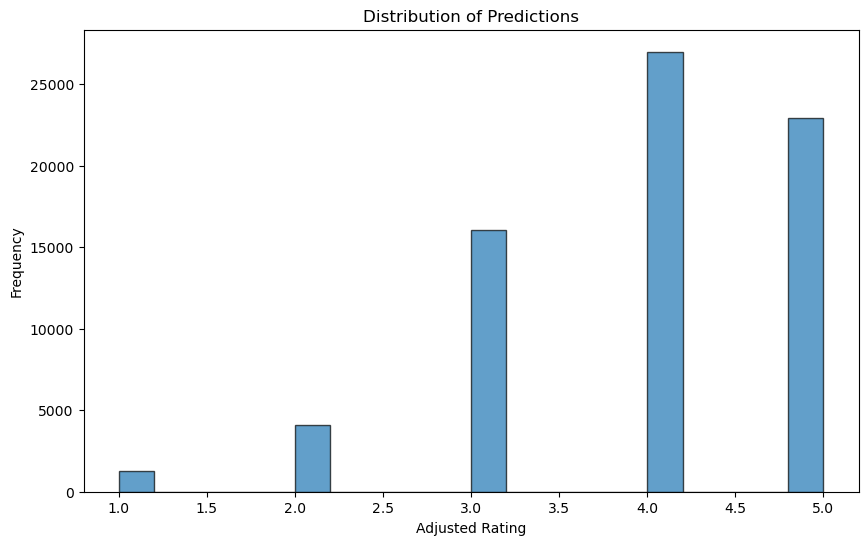

In [6]:
import matplotlib.pyplot as plt


# Plot the distribution of adjusted ratings
plt.figure(figsize=(10, 6))
plt.hist(test_df['rating'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Get rating counts
rating_counts = train_df['rating'].value_counts()

# Find the majority class size (highest count)
majority_count = rating_counts.max()

# Dictionary to store modified dataframes
modified_dfs = []

# Perform upsampling with slight noise addition for each class
for rating, count in rating_counts.items():
    class_df = train_df[train_df['rating'] == rating]
    
    # Duplicate rows based on the majority class size, ensuring the size of the class is adjusted
    num_duplicates = int(majority_count / count)  # Number of duplications required
    
    # Duplicate the class_df rows and add small random noise to the ratings
    duplicated_df = pd.concat([class_df] * num_duplicates, ignore_index=True)
    
    # Add random noise to the ratings
    duplicated_df['rating'] = duplicated_df['rating'] + np.random.uniform(-0.1, 0.1, size=duplicated_df.shape[0])
    # Ensure ratings are within the valid range (e.g., between 1 and 5)
    duplicated_df['rating'] = duplicated_df['rating'].clip(1, 5)
    modified_dfs.append(duplicated_df)

# Combine all modified data
balanced_train = pd.concat(modified_dfs)

# Shuffle dataset
train_df = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
# Log scale ratings
def normalise_ratings(train_data, test_data):
    min_rating = train_data['rating'].min()
    
    if min_rating < 0:
        train_data['rating'] = train_data['rating'] - min_rating
        test_data['rating'] = test_data['rating'] - min_rating

    train_data['rating'] = np.log1p(train_data['rating'])
    test_data['rating'] = np.log1p(test_data['rating'])

    return train_data, test_data, min_rating


import numpy as np

def denormalize_rating(log_scaled_ratings, min_rating=0):
    log_scaled_ratings = np.asarray(log_scaled_ratings, dtype=float)  # Ensure NumPy array

    # Reverse log1p transformation
    original_ratings = np.expm1(log_scaled_ratings)

    # Adjust for minimum rating
    if min_rating:
        original_ratings += min_rating

    # Clip values between 0 and 5
    return np.clip(original_ratings, 0, 5)

In [9]:
train_df, test_df, min_rating = normalise_ratings(train_df, test_df)

In [10]:
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
test_data = Dataset.load_from_df(test_df[['user_id', 'book_id', 'rating']], reader)
trainset = train_data.build_full_trainset()
testset = test_data.construct_testset([(uid, iid, r, {}) for uid, iid, r in test_df[['user_id', 'book_id', 'rating']].values])

In [ ]:
# Define the parameter grid
param_grid = { 
    'n_factors': [400],  
    'n_epochs': [250],  
    'reg_pu': [0.1],  # Regularization for user factors
    'reg_qi': [0.1],  # Regularization for item factors
    'lr_bu': [0.01],  # Learning rate for user bias
    'lr_bi': [0.01],  # Learning rate for item bias
    'random_state': [42]
}

# Define the grid search with GridSearchCV
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=2)

# Fit the grid search model
gs.fit(train_data)

# Get the best parameters and model
best_params = gs.best_params['rmse']
best_nmf = NMF(**best_params)
best_nmf.fit(trainset)

# Test the model
predictions = best_nmf.test(testset)

In [ ]:
# import joblib
# joblib.dump(best_nmf, '../Pickle/best_nmf_model.pkl')

In [ ]:
# Evaluation metrics: Precision, Recall, and nDCG at k
def precision_recall_ndcg_at_k(predictions, k, threshold):
    """Return precision, recall, and nDCG at k metrics for each user."""
    
    def dcg_at_k(scores, k):
        return sum([rel / log2(idx + 2) for idx, rel in enumerate(scores[:k])])

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    ndcgs = dict()
    
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        
        # nDCG@K
        actual = [true_r for (_, true_r) in user_ratings]
        ideal = sorted(actual, reverse=True)
        
        idcg = dcg_at_k(ideal, k)
        dcg = dcg_at_k([rel for (est, rel) in user_ratings], k)
        ndcgs[uid] = dcg / idcg if idcg > 0 else 0
    
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    ndcg = sum(ndcg for ndcg in ndcgs.values()) / len(ndcgs)
    
    return precision, recall, ndcg

# Compute the evaluation metrics
precision, recall, ndcg = precision_recall_ndcg_at_k(predictions, k=5, threshold=4.5)
print(f'Adjusted Precision: {precision}, Adjusted Recall: {recall}, Adjusted nDCG: {ndcg}')


In [ ]:
est_ratings = np.array([pred.est for pred in predictions], dtype=float)

In [ ]:
true_ratings = np.array([pred.r_ui for pred in predictions], dtype=float)

In [ ]:
true_ratings = denormalize_rating(true_ratings)

In [ ]:
est_ratings = denormalize_rating(est_ratings)

In [ ]:
import matplotlib.pyplot as plt


# Plot the distribution of adjusted ratings
plt.figure(figsize=(10, 6))
plt.hist(est_ratings, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import matplotlib.pyplot as plt


# Plot the distribution of adjusted ratings
plt.figure(figsize=(10, 6))
plt.hist(true_ratings, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
true_ratings.mean()

In [ ]:
est_ratings.mean()

In [ ]:
import shap

# Create a SHAP explainer and explain a prediction
explainer = shap.KernelExplainer(best_nmf.predict, train_data)
shap_values = explainer.shap_values(testset)

# Plot SHAP values
shap.summary_plot(shap_values, testset)
